In [1]:
import pandas as pd
import numpy as np
import sys    
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Function that returns the size of an object in MB
def size(obj):
     return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

In [3]:
orders=pd.read_csv('data_sets/order_products__prior.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (1048575, 4);   size: 33.55 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [5]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (1048575,);   size: 16.78 MB;   unique_orders: 104042;   unique_items: 35449


In [6]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().as_matrix()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns] 

In [7]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)



In [8]:
%%time
rules = association_rules(orders, 0.01)  

Starting order_item:                1048575
Items with support >= 0.01:           10984
Remaining order_item:                969090
Remaining orders with 2+ items:       97533
Remaining order_item:                963196
Item pairs:                         3767829
Item pairs with support >= 0.01:      55355

Wall time: 1min 6s


In [9]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('data_sets/products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Uncured Bacon + Cranberry Bison Bar,"Turkey Bar, Almond + Cranberry",10,0.010253,33,0.033835,25,0.025632,0.303030,0.400000,11.822182
1,Gobble Gobble Turkey Pouch Stage 3,Stage 3 Hearty Meals - Chick Chick Organic Bab...,12,0.012304,30,0.030759,35,0.035885,0.400000,0.342857,11.146629
2,Organic Nondairy Strawberry Cashew Yogurt,Organic Cashew Nondairy Blueberry Yogurt,10,0.010253,35,0.035885,27,0.027683,0.285714,0.370370,10.320952
3,Organic Stage 3 Zucchini Broccoli Medley Baby ...,Organic Spring Vegetables & Pasta Stage 3 Baby...,10,0.010253,44,0.045113,22,0.022556,0.227273,0.454545,10.075723
5,Antioxidant Infusions Brasilia Blueberry,Antioxidant Infusions Costa Rica Clementine,11,0.011278,34,0.034860,34,0.034860,0.323529,0.323529,9.280822
6,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,10,0.010253,40,0.041012,27,0.027683,0.250000,0.370370,9.030833
7,Cream on Top Strawberry Organic Yogurt,Organic Blueberry Cream On Top Whole Milk Yogurt,13,0.013329,41,0.042037,35,0.035885,0.317073,0.371429,8.835742
4,Tender Chicken & Stars Stage 3,Organic Spring Vegetables & Pasta Stage 3 Baby...,10,0.010253,55,0.056391,22,0.022556,0.181818,0.454545,8.060579
8,Baby Food Pouch - Roasted Carrot Spinach & Beans,Baby Food Pouch - Spinach Pumpkin & Chickpea,12,0.012304,53,0.054341,28,0.028708,0.226415,0.428571,7.886765
10,Yerba Mate Sparkling Classic Gold,Cranberry Pomegranate Sparkling Yerba Mate,15,0.015379,47,0.048189,40,0.041012,0.319149,0.375000,7.781888


In [14]:
rules_final.describe()

,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
count,55355.000000,55355.000000,55355.000000,55355.000000,55355.000000,55355.000000,55355.000000,55355.000000,55355.000000
mean,24.131244,0.024742,3068.542878,3.146159,2086.745786,2.139528,0.022666,0.040427,0.035759
std,34.321150,0.035189,3900.005071,3.998652,3010.670068,3.086822,0.027470,0.051457,0.246504
min,10.000000,0.010253,24.000000,0.024607,21.000000,0.021531,0.000650,0.000650,0.000082
25%,12.000000,0.012304,598.000000,0.613126,363.000000,0.372182,0.005190,0.007463,0.007993
50%,15.000000,0.015379,1601.000000,1.641496,945.000000,0.968903,0.012870,0.020464,0.011160
75%,24.000000,0.024607,3418.000000,3.504455,2385.000000,2.445326,0.029915,0.050122,0.015881
max,1311.000000,1.344160,15377.000000,15.765946,15377.000000,15.765946,0.416667,0.545455,11.822182


In [16]:
import seaborn as sns

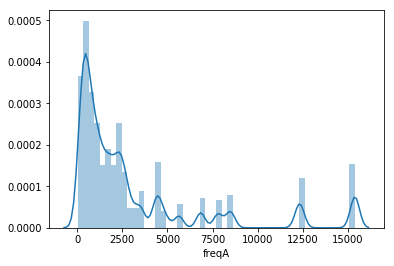

In [16]:
sns.distplot(rules_final['freqA'])

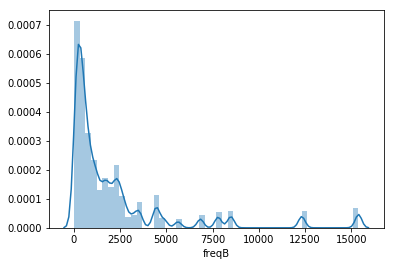

In [17]:
sns.distplot(rules_final['freqB'])

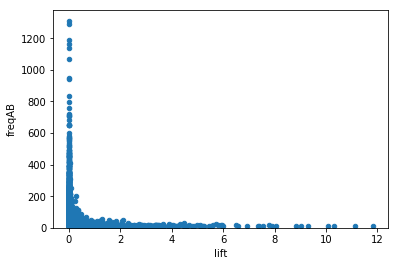

In [18]:
var = 'lift'
data = pd.concat([rules_final['freqAB'], rules_final[var]], axis=1)
data.plot.scatter(x=var, y='freqAB', ylim=(0.001));

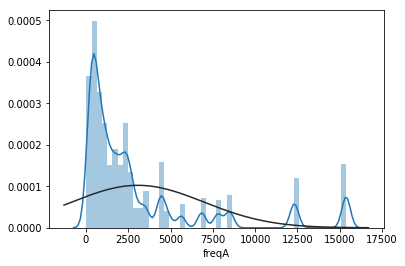

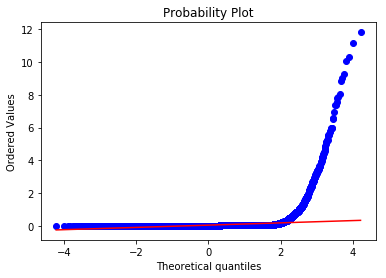

In [19]:
#histogram and normal probability plot
sns.distplot(rules_final['freqA'], fit=norm);
fig = plt.figure()
res = stats.probplot(rules_final['lift'], plot=plt)

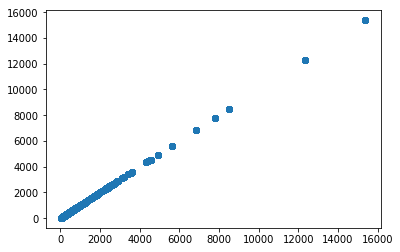

In [32]:
plt.scatter(rules_final['freqA'], rules_final['freqA']);

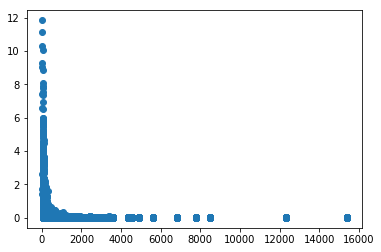

In [23]:
plt.scatter(rules_final[rules_final['freqA']>10]['freqA'], rules_final[rules_final['freqA']>10]['lift']);

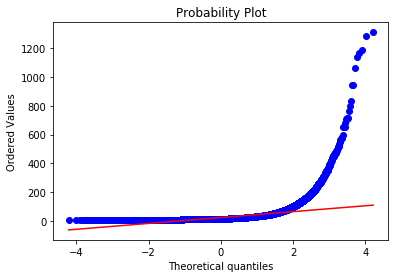

In [30]:
res = stats.probplot(rules_final['freqAB'], plot=plt)

In [11]:
topRule=rules_final[1:10]

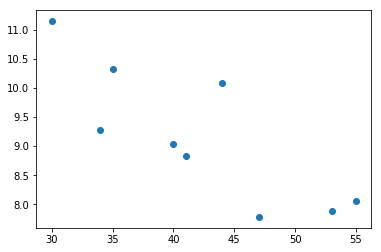

In [26]:
plt.scatter(topRule[topRule['freqA']>10]['freqA'], topRule[rules_final['freqA']>10]['lift']);

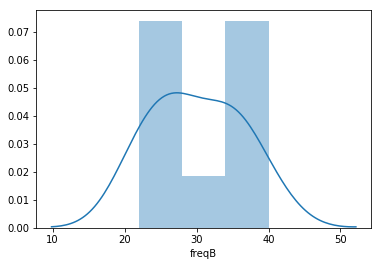

In [31]:
sns.distplot(topRule['freqB'])